In [1]:
#gets all this setup
import time
start_time = time.time()
from transformers import BertTokenizer
from pathlib import Path
import torch

from box import Box
import pandas as pd
import collections
import os
from tqdm import tqdm, trange
import sys
import random
import numpy as np
# import apex
from sklearn.model_selection import train_test_split

import datetime

import sys
sys.path.append('../')

from fast_bert.modeling import BertForMultiLabelSequenceClassification
from fast_bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from fast_bert.learner_cls import BertLearner
# from fast_bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc, accuracy
from fast_bert.metrics import *

torch.cuda.empty_cache()

pd.set_option('display.max_colwidth', -1)
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')

# LOG_PATH=Path('/scratch/da2734/twitter/sana/log/')
# DATA_PATH=Path('/scratch/da2734/twitter/sana/data')
# LABEL_PATH=Path('/scratch/da2734/twitter/sana/data/')
# OUTPUT_PATH=Path('/scratch/da2734/twitter/sana/output/')
LOG_PATH=Path('../mturk_mar6/log/')
DATA_PATH=Path('../mturk_mar6/data')
LABEL_PATH=Path('../mturk_mar6/data/')
OUTPUT_PATH=Path('../mturk_mar6/output_100')
FINETUNED_PATH = None

args = Box({
    "run_text": "multilabel toxic comments with freezable layers",
    "train_size": -1,
    "val_size": -1,
    "log_path": LOG_PATH,
    "full_data_dir": DATA_PATH,
    "data_dir": DATA_PATH,
    "task_name": "labor_market_classification",
    "no_cuda": False,
#     "bert_model": BERT_PRETRAINED_PATH,
    "output_dir": OUTPUT_PATH,
    "max_seq_length": 512,
    "do_train": True,
    "do_eval": True,
    "do_lower_case": True,
    "train_batch_size": 8,
    "eval_batch_size": 200,
    "learning_rate": 5e-5,
    "num_train_epochs": 6,
    "warmup_proportion": 0.0,
    "no_cuda": False,
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,
    "fp16": False,
    "fp16_opt_level": "O1",
    "weight_decay": 0.0,
    "adam_epsilon": 1e-8,
    "max_grad_norm": 1.0,
    "max_steps": -1,
    "warmup_steps": 500,
    "logging_steps": 50,
    "eval_all_checkpoints": True,
    "overwrite_output_dir": True,
    "overwrite_cache": False,
    "seed": 42,
    "loss_scale": 128,
    "task_name": 'intent',
    "model_name": 'bert-base-uncased',
    "model_type": 'bert'
})

import logging

logfile = str(LOG_PATH/'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
    datefmt='%m/%d/%Y %H:%M:%S',
    handlers=[
        logging.FileHandler(logfile),
        logging.StreamHandler(sys.stdout)
    ])

logger = logging.getLogger()

# logger.info(args)

device = torch.device('cpu')
if torch.cuda.device_count() > 1:
    args.multi_gpu = True
else:
    args.multi_gpu = False

label_cols = ["job_loss","is_unemployed","job_search","is_hired","job_offer"]

# databunch defined here https://github.com/kaushaltrivedi/fast-bert/blob/master/fast_bert/data_cls.py
databunch = BertDataBunch(
                        args['data_dir'], 
                        LABEL_PATH, 
                        args.model_name, 
                        train_file='train.csv', 
                        val_file='val.csv',
                        # test_data='test.csv',
                        text_col="text", #this is the name of the column in the train file that containts the tweet text
                        label_col=label_cols,
                        batch_size_per_gpu=args['train_batch_size'], 
                        max_seq_length=args['max_seq_length'], 
                        multi_gpu=args.multi_gpu, 
                        multi_label=True, 
                        model_type=args.model_type)

num_labels = len(databunch.labels)
print('num_labels', num_labels)

# print('__Python VERSION:', sys.version)
# print('__pyTorch VERSION:', torch.__version__)
# print('__CUDA VERSION')
# print('__CUDNN VERSION:', torch.backends.cudnn.version())
# print('__Number CUDA Devices:', torch.cuda.device_count())
# print('__Devices')
# print('Active CUDA Device: GPU', torch.cuda.current_device())

# print ('Available devices ', torch.cuda.device_count())
# print ('Current cuda device ', torch.cuda.current_device)

# metrics defined: https://github.com/kaushaltrivedi/fast-bert/blob/d89e2aa01d948d6d3cdea7ad106bf5792fea7dfa/fast_bert/metrics.py
metrics = []
metrics.append({'name': 'accuracy_thresh', 'function': accuracy_thresh})
metrics.append({'name': 'roc_auc', 'function': roc_auc})
metrics.append({'name': 'roc_auc_save_to_plot', 'function': roc_auc_save_to_plot})
metrics.append({'name': 'fbeta', 'function': fbeta})
metrics.append({'name': 'accuracy', 'function': accuracy})
metrics.append({'name': 'accuracy_multilabel', 'function': accuracy_multilabel})


learner = BertLearner.from_pretrained_model(
                                            databunch, 
                                            pretrained_path='../mturk_mar6/output_100/model_out/', 
                                            metrics=metrics, 
                                            device=device, 
                                            logger=logger, 
                                            output_dir=args.output_dir, 
                                            finetuned_wgts_path=FINETUNED_PATH, 
                                            warmup_steps=args.warmup_steps,
                                            multi_gpu=args.multi_gpu, 
                                            is_fp16=args.fp16, 
                                            multi_label=True, 
                                            logging_steps=0)

print('time taken to load all this stuff:', str(time.time() - start_time), 'seconds')



03/20/2020 15:58:16 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /Users/dval/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
03/20/2020 15:58:16 - INFO - root -   Loading features from cached file ../mturk_mar6/data/cache/cached_bert_train_multi_label_512_train.csv
03/20/2020 15:58:16 - INFO - root -   Loading features from cached file ../mturk_mar6/data/cache/cached_bert_dev_multi_label_512_val.csv
num_labels 5
03/20/2020 15:58:16 - INFO - transformers.configuration_utils -   loading configuration file ../mturk_mar6/output_100/model_out/config.json
03/20/2020 15:58:16 - INFO - transformers.configuration_utils -   Model config {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": f

In [2]:
# from fast_bert.metrics import *
# learner.validate()

In [10]:
val = pd.read_csv('../mturk_mar6/data/val.csv')
print(val.shape)
# start_time = time.time()
texts = val['text'].values.tolist()
print(len(texts))
# print('time taken:', str(time.time() - start_time), 'seconds')
predictions = learner.predict_batch(texts)
# predictions.head()
# predictions_df = pd.DataFrame(predictions)


(737, 7)
737
03/20/2020 17:56:12 - INFO - root -   Writing example 0 of 737


In [22]:
prediction_df = pd.DataFrame(
[dict(prediction) for prediction in predictions],
index=val.id).rename(columns={
'is_unemployed':'is_unemployed_model',
'job_search':'job_search_model',
'is_hired_1mo':'is_hired_1mo_model',
'lost_job_1mo':'lost_job_1mo_model',
'job_offer':'job_offer_model',
})

prediction_df

,job_offer_model,job_search_model,is_unemployed_model,is_hired_1mo_model,lost_job_1mo_model
id,,,,,
2949,0.133859,0.050503,0.032645,0.023756,0.018106
2950,0.027588,0.170792,0.232549,0.264211,0.211256
2951,0.034374,0.187477,0.277772,0.345099,0.276405
2952,0.070351,0.071965,0.040677,0.039852,0.022013
2953,0.020380,0.104445,0.155159,0.147558,0.126848
...,...,...,...,...,...
3681,0.069247,0.236974,0.350636,0.436420,0.411159
3682,0.359984,0.055237,0.025958,0.022975,0.016116
3683,0.027466,0.082786,0.168996,0.065147,0.085974


In [7]:
val.head()

,id,text,is_unemployed,lost_job_1mo,job_search,is_hired_1mo,job_offer
0,2949,Idiot attention-seeking Obama groupie. You are not worthy of a position of service to your country. YOUR FIRED! HAHA https://t.co/OxjzfboJ4J,0,0,0,0,0
1,2950,Last night I applied for a full-time good-pay position as a haha I wish but nOW I HAVE AN INTERVIEW ON WEDNESDAY???,1,0,1,0,0
2,2951,I was asked to take a supervisor position this morning and I said yaaaas lol,0,0,0,0,0
3,2952,this chick who took the position i applie to stopped showing up so my chances are high.,0,0,1,0,0
4,2953,@KoderKev HR did say the shorter they needed me for the temp the better it would be for the permanent position but it feels like I was fired,1,1,0,0,0


In [25]:
merged = prediction_df.merge(val, on='id')
merged

,id,job_offer_model,job_search_model,is_unemployed_model,is_hired_1mo_model,lost_job_1mo_model,text,is_unemployed,lost_job_1mo,job_search,is_hired_1mo,job_offer
0,2949,0.133859,0.050503,0.032645,0.023756,0.018106,Idiot attention-seeking Obama groupie. You are not worthy of a position of service to your country. YOUR FIRED! HAHA https://t.co/OxjzfboJ4J,0,0,0,0,0
1,2950,0.027588,0.170792,0.232549,0.264211,0.211256,Last night I applied for a full-time good-pay position as a haha I wish but nOW I HAVE AN INTERVIEW ON WEDNESDAY???,1,0,1,0,0
2,2951,0.034374,0.187477,0.277772,0.345099,0.276405,I was asked to take a supervisor position this morning and I said yaaaas lol,0,0,0,0,0
3,2952,0.070351,0.071965,0.040677,0.039852,0.022013,this chick who took the position i applie to stopped showing up so my chances are high.,0,0,1,0,0
4,2953,0.020380,0.104445,0.155159,0.147558,0.126848,@KoderKev HR did say the shorter they needed me for the temp the better it would be for the permanent position but it feels like I was fired,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
732,3681,0.069247,0.236974,0.350636,0.436420,0.411159,Got hired today!!!,0,0,0,1,0
733,3682,0.359984,0.055237,0.025958,0.022975,0.016116,Looking to get hired? Avoid these pitfalls https://t.co/HBNU1iKQZv tip @LinkedInPulse,0,0,0,0,0
734,3683,0.027466,0.082786,0.168996,0.065147,0.085974,WOOOO one step closer to not being unemployed! #hired #wwddd https://t.co/ORocOEKpa0,1,0,0,1,0
735,3684,0.733331,0.067099,0.028900,0.031608,0.021769,Anyone looking for a part time position in the St. Paul MN area? Message me for more details! #jobs #hiring #stpaul #sales #merchandising,0,0,0,0,1


is_unemployed filtered time taken: 8607.540324926376 seconds
03/20/2020 18:21:42 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.
lost_job_1mo filtered time taken: 8607.669699907303 seconds
03/20/2020 18:21:42 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.
job_search filtered time taken: 8607.785571813583 seconds
03/20/2020 18:21:43 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.
is_hired_1mo filtered time taken: 8607.917254924774 seconds
03/20/2020 18:21:43 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.
job_offer filtered time taken: 8608.054364919662 seconds
03/20/2020 18:21:43 - WARNING - matplotlib.legend -   No handles with labels found to put in legend.


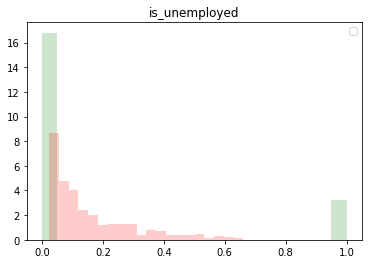

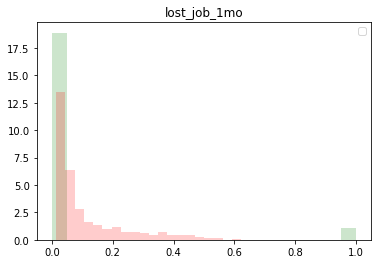

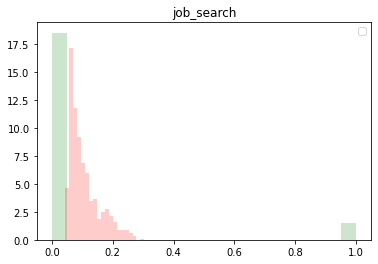

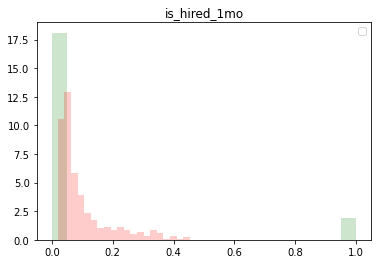

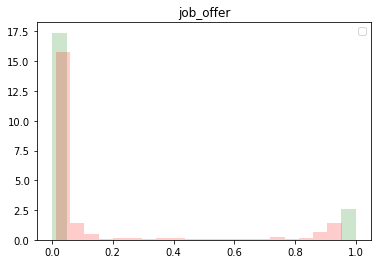

In [39]:
import matplotlib.pyplot as plt
columns = ['is_unemployed', 'lost_job_1mo', 'job_search',
       'is_hired_1mo', 'job_offer']
for column in columns:
#     start_time = time.time()
#     all_filtered_boundary = merged_filtered.loc[(merged_filtered[column] >= threshold - boundary_width) &
#                                                 (merged_filtered[column] <= threshold + boundary_width)]
#     all_filtered_boundary.to_csv('../mturk_mar6/boundary/filtered_{}.csv'.format(column))
    # print(all_filtered_boundary['text'])
    print(column, 'filtered time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.hist(merged[column], bins=20, density = True, color = 'green', alpha = 0.2)
    plt.hist(merged[column+'_model'], bins=20, density = True, color = 'red', alpha = 0.2)
    ax.set_yscale('log')

    # plt..yscale(value)
    plt.title(column)
    ax.legend()
    #plt.show()
    plt.savefig('../mturk_mar6/boundary_debug/val_{}.png'.format(column))

#     print(column, 'plot filtered time taken:', str(time.time() - start_time), 'seconds')

In [40]:
train = pd.read_csv('../mturk_mar6/data/train.csv')
print(train.shape)
# start_time = time.time()
texts = train['text'].values.tolist()
print(len(texts))

start_time = time.time()
predictions = learner.predict_batch(texts)
print('time taken:', str(time.time() - start_time), 'seconds')

# predictions.head()
# predictions_df = pd.DataFrame(predictions)

prediction_df = pd.DataFrame(
[dict(prediction) for prediction in predictions],
index=train.id).rename(columns={
'is_unemployed':'is_unemployed_model',
'job_search':'job_search_model',
'is_hired_1mo':'is_hired_1mo_model',
'lost_job_1mo':'lost_job_1mo_model',
'job_offer':'job_offer_model',
})

print(prediction_df.head())

merged = prediction_df.merge(train, on='id')


(2948, 7)
2948
03/20/2020 18:24:26 - INFO - root -   Writing example 0 of 2948


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
columns = ['is_unemployed', 'lost_job_1mo', 'job_search',
       'is_hired_1mo', 'job_offer']
for column in columns:
#     start_time = time.time()
#     all_filtered_boundary = merged_filtered.loc[(merged_filtered[column] >= threshold - boundary_width) &
#                                                 (merged_filtered[column] <= threshold + boundary_width)]
#     all_filtered_boundary.to_csv('../mturk_mar6/boundary/filtered_{}.csv'.format(column))
    # print(all_filtered_boundary['text'])
    print(column, 'filtered time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.hist(merged[column], bins=20, density = True, color = 'green', alpha = 0.2)
    plt.hist(merged[column+'_model'], bins=20, density = True, color = 'red', alpha = 0.2)
#     ax.set_yscale('log')

    # plt..yscale(value)
    plt.title(column)
    ax.legend()
    #plt.show()
    plt.savefig('../mturk_mar6/boundary_debug/train_{}.png'.format(column))

#     print(column, 'plot filtered time taken:', str(time.time() - start_time), 'seconds')